# Building a CNN for Sports Image Classification

The goal of this project is to build a Neural Network for Image Classification. Having learned a few things about Computer Vision in class recently, I would like to try to build a Convolutional Neural Network (CNN) to classify some images. The dataset that I will be using comes form Kaggle.

The strategy for this task is following : first, we need to load the data and create two sets, a training set and a test set ; then, we need to build the CNN : in order to do that, we will use a model that I built in class for a similar task (MNIST Digit Classification) and we will adapt it to our needs. Finally, we will test our tuned model and compute the accuracy.

In [65]:
import tensorflow as tf
from tensorflow.python.keras import layers
import pandas as pd
from matplotlib import image as img
from matplotlib import pyplot as plt
import numpy as np

## Loading the data and creating sets :

We will load the dataset (that we have already downloaded from Kaggle) and we are going to modify it a little bit :
- First, we only take the rows where the associated image is in "jpg" format (only 1 image was is a weird format, so we took it out)
- Then, we selected 2 sports (too many in the dataset) and we filtered the dataset to keep only the rows of interest
- Finally, we shuffled the dataset and reset the indexes

In [66]:
dataset = pd.read_csv("sports.csv")
print(dataset.shape)
dataset_jpg = dataset[dataset['filepaths'].str.lower().str.endswith('.jpg')]
print(dataset_jpg.shape)

selected_sports=["basketball","football"]
dataset_filter = dataset[dataset["labels"].isin(selected_sports)]
print(dataset_filter.shape)

dataset = dataset_filter.reset_index(drop=True)
dataset = dataset.sample(frac=1).reset_index(drop=True)

(14493, 4)
(14492, 4)
(380, 4)


Those numbers tell us that only one image was not a "jpg" and that only 380 images represent basketball or football.

We can show a random image from the filtered dataset :

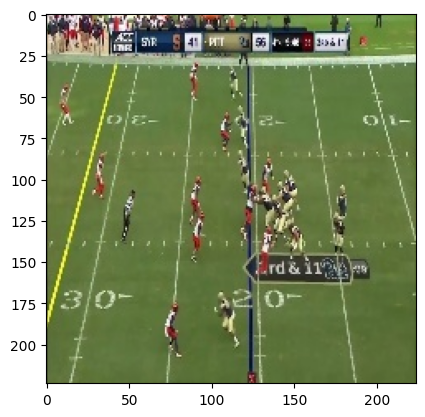

In [67]:
sample_image_path = dataset["filepaths"][0]
image = img.imread(sample_image_path)
plt.imshow(image)
plt.show()

Now we have to create a trainign set and a test set : the downloaded archive has 3 images folders (training, validation and testing). For the sake of simplicity we will only use the training and the testing folders for our binary classification model. For the labels we use an encoder, which is often good practice when working with non-numerical arguments.

In [68]:
train_set = dataset[dataset["data set"] == "train"]
test_set = dataset[dataset["data set"] == "test"]

y_train = train_set["labels"]
y_test = test_set["labels"]

print(train_set)

label_mapping = {'basketball': 0, 'football': 1}

y_train = y_train.map(label_mapping)
y_test = y_test.map(label_mapping)

print(y_train)

     class id                 filepaths      labels data set
0          31    train/football/137.jpg    football    train
1           8  train/basketball/112.jpg  basketball    train
3          31    train/football/003.jpg    football    train
4          31    train/football/157.jpg    football    train
5           8  train/basketball/088.jpg  basketball    train
..        ...                       ...         ...      ...
375         8  train/basketball/070.jpg  basketball    train
376         8  train/basketball/081.jpg  basketball    train
377         8  train/basketball/165.jpg  basketball    train
378         8  train/basketball/015.jpg  basketball    train
379        31    train/football/064.jpg    football    train

[360 rows x 4 columns]
0      1
1      0
3      1
4      1
5      0
      ..
375    0
376    0
377    0
378    0
379    1
Name: labels, Length: 360, dtype: int64


We then create two sets : trainign and testing. Each set is a list of images, each image represented as an array.

In [69]:
x_train = []
for path in train_set["filepaths"]:
    image = img.imread(path)
    img_array = np.asarray(image)
    x_train.append(img_array)

x_test = []
for path in test_set["filepaths"]:
    image = img.imread(path)
    img_array = np.asarray(image)
    x_test.append(img_array)

We modify those lists to have them in an array format (esaier to manipulate) : 

In [70]:
x_train = np.array(x_train)
x_test = np.array(x_test)

y_train = np.array(y_train)
y_test = np.array(y_test)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(360, 224, 224, 3)
(10, 224, 224, 3)
(360,)
(10,)


Those numbers tell us the sizes of our data : we can see (and it is always good to check it !) that the data and the labels correspond to each other (in terms of shape).  

## Building the models :
  
Next we are going to build our model: as I mentionned before, I have already built a simple CNN model in class for a project. I did use a similar model here, I just made some minor modifications to fit the shape of the data.  

- The first model is **CNN_model_binary** . It will be used for two classes classification (which is what we want to do here).
- The second model is **CNN_model_multiclass**. As you have probably already guessed, it will be used for multiclass classification problems.
  

In [71]:
def CNN_model_binary(input_shape, num_classes):

    model = tf.keras.models.Sequential()
    
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Flatten())
    
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))

    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

In [72]:
def CNN_model_multiclass(input_shape, num_classes):

    model = tf.keras.models.Sequential()
    
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Flatten())
    
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))

    model.add(layers.Dense(3, activation='softmax'))
    
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

Next we have to create a function that will train our models with our data. I only used one function for both models, but we have to be aware that each model has a specific treatment: for example, when using more than two classes, we have to do some **One Hot Encoding**.

In [73]:
def trainAndPredictCNN(x_train, y_train, x_test, y_test,classes, n_epoch = 10, batch = 64):

    #x_train = x_train.reshape(x_train.shape).astype('float32') 
    #x_test = x_test.reshape(x_test.shape).astype('float32')

    x_train = x_train/255
    x_test = x_test/255

    if classes > 2 :
        y_train = tf.keras.utils.to_categorical(y_train, num_classes= classes)
        y_test = tf.keras.utils.to_categorical(y_test, num_classes= classes)
        model = CNN_model_multiclass(x_train.shape, classes)
    else :
        model = CNN_model_binary(x_train.shape, classes)

    model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=n_epoch, batch_size=batch, verbose=2)

    scores = model.evaluate(x_test, y_test, verbose=0) 
    #print("Baseline Error: {:.2f}".format(100-scores[1]*100))
    print(scores)

    return

## Testing our first model: Binary Classification

Now that have built everything that we need to make some predictions, let's test our first model for binary classification :

In [74]:
trainAndPredictCNN(x_train, y_train, x_test, y_test,2,10,32)

Epoch 1/10
12/12 - 11s - loss: 0.7727 - accuracy: 0.4778 - val_loss: 0.6919 - val_accuracy: 0.6000 - 11s/epoch - 885ms/step
Epoch 2/10
12/12 - 10s - loss: 0.6797 - accuracy: 0.6389 - val_loss: 0.6248 - val_accuracy: 0.7000 - 10s/epoch - 810ms/step
Epoch 3/10
12/12 - 10s - loss: 0.6218 - accuracy: 0.6500 - val_loss: 0.6176 - val_accuracy: 0.6000 - 10s/epoch - 809ms/step
Epoch 4/10
12/12 - 10s - loss: 0.4880 - accuracy: 0.7694 - val_loss: 0.5695 - val_accuracy: 0.8000 - 10s/epoch - 808ms/step
Epoch 5/10
12/12 - 10s - loss: 0.4141 - accuracy: 0.8167 - val_loss: 0.4629 - val_accuracy: 0.9000 - 10s/epoch - 810ms/step
Epoch 6/10
12/12 - 10s - loss: 0.3057 - accuracy: 0.8778 - val_loss: 0.3890 - val_accuracy: 0.8000 - 10s/epoch - 808ms/step
Epoch 7/10
12/12 - 10s - loss: 0.1899 - accuracy: 0.9333 - val_loss: 0.2044 - val_accuracy: 0.9000 - 10s/epoch - 810ms/step
Epoch 8/10
12/12 - 10s - loss: 0.1047 - accuracy: 0.9556 - val_loss: 0.1036 - val_accuracy: 1.0000 - 10s/epoch - 821ms/step
Epoch 9/


**Comments** : We only used 10 epochs as using more did not generate better results. It is also important to keep in mind that our test set only contains 10 images, which can be very limiting, but sufficent our small model.     

We can see that after 10 epochs, our model is able to clasiffy 9/10 images in general (90% accuracy, very volatile for so few testing images).    
  
## Testing our second model: multiclass classification (with a twist):   
  
We will now test our second model (multiclass classification). But we will make some small changes to our data: we are going to integrate our validation data in the testing data in order to increase the size of the test set. We will reiterate previous steps to select 3 sports, basketball, football and skydiving (why not?) and to increase the size of the test set.



In [75]:
dataset = pd.read_csv("sports.csv")
print(dataset.shape)
dataset_jpg = dataset[dataset['filepaths'].str.lower().str.endswith('.jpg')]
print(dataset_jpg.shape)

selected_sports=["basketball","football","skydiving"]
dataset_filter = dataset[dataset["labels"].isin(selected_sports)]
print(dataset_filter.shape)

dataset = dataset_filter.reset_index(drop=True)
dataset = dataset.sample(frac=1).reset_index(drop=True)

(14493, 4)
(14492, 4)
(538, 4)


In [76]:
list = ["valid","test"]

train_set = dataset[dataset["data set"] == "train"]
test_set = dataset[dataset["data set"].isin(list)]

y_train = train_set["labels"]
y_test = test_set["labels"]

print(train_set)

label_mapping = {'basketball': 0, 'football': 1, 'skydiving': 2}

y_train = y_train.map(label_mapping)
y_test = y_test.map(label_mapping)

print(y_train)

     class id                 filepaths      labels data set
0          31    train/football/060.jpg    football    train
1           8  train/basketball/153.jpg  basketball    train
2          78   train/skydiving/053.jpg   skydiving    train
3          31    train/football/089.jpg    football    train
4           8  train/basketball/130.jpg  basketball    train
..        ...                       ...         ...      ...
533        78   train/skydiving/131.jpg   skydiving    train
534        31    train/football/017.jpg    football    train
535         8  train/basketball/021.jpg  basketball    train
536        31    train/football/130.jpg    football    train
537        78   train/skydiving/116.jpg   skydiving    train

[508 rows x 4 columns]
0      1
1      0
2      2
3      1
4      0
      ..
533    2
534    1
535    0
536    1
537    2
Name: labels, Length: 508, dtype: int64


In [77]:
x_train = []
for path in train_set["filepaths"]:
    image = img.imread(path)
    img_array = np.asarray(image)
    x_train.append(img_array)

x_test = []
for path in test_set["filepaths"]:
    image = img.imread(path)
    img_array = np.asarray(image)
    x_test.append(img_array)

In [78]:
x_train = np.array(x_train)
x_test = np.array(x_test)

y_train = np.array(y_train)
y_test = np.array(y_test)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(508, 224, 224, 3)
(30, 224, 224, 3)
(508,)
(30,)


Now is the moment of truth, we will test our second model (multiclass classification) on the new sets:

In [79]:
trainAndPredictCNN(x_train, y_train, x_test, y_test,3,10,32)

Epoch 1/10
16/16 - 15s - loss: 1.2920 - accuracy: 0.4646 - val_loss: 0.7831 - val_accuracy: 0.6000 - 15s/epoch - 933ms/step
Epoch 2/10
16/16 - 14s - loss: 0.6181 - accuracy: 0.7500 - val_loss: 0.3749 - val_accuracy: 0.8333 - 14s/epoch - 882ms/step
Epoch 3/10
16/16 - 14s - loss: 0.4325 - accuracy: 0.8130 - val_loss: 0.4148 - val_accuracy: 0.7667 - 14s/epoch - 874ms/step
Epoch 4/10
16/16 - 14s - loss: 0.4328 - accuracy: 0.8327 - val_loss: 0.4053 - val_accuracy: 0.8000 - 14s/epoch - 877ms/step
Epoch 5/10
16/16 - 14s - loss: 0.3033 - accuracy: 0.8780 - val_loss: 0.6494 - val_accuracy: 0.6667 - 14s/epoch - 874ms/step
Epoch 6/10
16/16 - 14s - loss: 0.2214 - accuracy: 0.9232 - val_loss: 0.2816 - val_accuracy: 0.9000 - 14s/epoch - 873ms/step
Epoch 7/10
16/16 - 14s - loss: 0.0836 - accuracy: 0.9764 - val_loss: 0.3529 - val_accuracy: 0.8667 - 14s/epoch - 877ms/step
Epoch 8/10
16/16 - 14s - loss: 0.0491 - accuracy: 0.9882 - val_loss: 0.3059 - val_accuracy: 0.8667 - 14s/epoch - 873ms/step
Epoch 9/

**Comments**: Here we are able to achieve a global accuracy of around 90% (93% after the last round of training).